# Расчет теплоемкости

In [1]:
%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

def celcius_to_kelvin( temp ):
    return [ t + 273.15 for t in temp ]

def read_file( filename, n ):
    with open( filename, mode = 'r' ) as inputfile:
        lines = inputfile.readlines()

    lists = [ [] for i in range(n) ] 
    for line in lines:
        data = line.split(',')
        if '#' not in line and len(line.split()) > 0:
            for i, l in zip(range(n), lists):
                l.append( float(data[i]) )

    return lists 

# all-mighty plotting function
def plot( time, temp, dsc, dsc_corr = [], dsc_corr_bline = [], bounds = [] ):
    if bounds:
        print(bounds)
        
        # linearly approximating first piece
        fp, residual, rank, sv, rcond = sp.polyfit( time[bounds[0][0]:bounds[0][1]], dsc[bounds[0][0]:bounds[0][1]], 1, full = True )
        f = sp.poly1d( fp )
        mean_value = fp[0] * 0.5 * (time[bounds[0][1]] + time[bounds[0][0]]) + fp[1] 
        #print('mean_value: {0}'.format(mean_value))

        # linearly approximating second piece
        fp2, residual, rank, sv, rcond = sp.polyfit( time[bounds[1][0]:bounds[1][1]], dsc[bounds[1][0]:bounds[1][1]], 1, full = True )
        f2 = sp.poly1d( fp2 )
        mean_value2 = fp2[0] * 0.5 * (time[bounds[1][1]] + time[bounds[1][0]]) + fp2[1]  
        #print('mean_value2: {0}'.format(mean_value2))
        
        # connecting them with a line
        fp3, residual, rank, sv, rcond = sp.polyfit( [ time[bounds[0][1]], time[bounds[1][0]] ], [mean_value, mean_value2], 1, full = True )
        f3 = sp.poly1d( fp3 )
        
    fig, ax1 = plt.subplots()
    plt.grid( linestyle = ':', alpha = 0.7 )
    
    s = 1
    lw = 2.0
    
    ax1.scatter( time, temp, color = 'r', s = s, marker = 'o' )
    ax1.set_xlabel('time(min)')
    ax1.set_ylabel('Temperature, K', color = 'r')
    ax1.tick_params('y', colors = 'r')

    ax2 = ax1.twinx()
    ax2.scatter( time, dsc, color = 'k', s = s, marker = 'o' )
    
    if dsc_corr: 
        ax2.scatter( time, dsc_corr, color = 'g', s = s, marker = 'o' )
        ax2.axhline( y = 0, xmin = 0.0, xmax = 1.0, color = 'k', lw = 1, linestyle = 'dashed', alpha = 0.7)
    if dsc_corr_bline:
        ax2.scatter( time, dsc_corr_bline, color = 'b', s = s, marker = 'o' )
    
    ax2.set_ylabel('DSC signal', color = 'k' )
    ax2.tick_params('y', colors = 'k')


    if bounds:
        x = np.linspace( time[bounds[0][0]], time[bounds[0][1]], 100)
        ax2.plot( x, f(x), color = 'y', lw = lw, linestyle = 'dashed')
        x = np.linspace( time[bounds[1][0]], time[bounds[1][1]], 100)
        ax2.plot( x, f2(x), color = 'y', lw = lw, linestyle = 'dashed')
        x = np.linspace( time[bounds[0][1]], time[bounds[1][0]], 100)
        ax2.plot( x, f3(x), color = 'r', lw = lw, linestyle = 'dashed')
        
        return [ [time[bounds[0][1]], time[bounds[1][0]]], 
                 [mean_value, mean_value2] ]

def remove_drift( time, dsc, means ):
    fp, residual, rank, sv, rcond = sp.polyfit( means[0], means[1], 1, full = True )
    
    dsc_rm_drift = []
    for t, d in zip( time, dsc ):
        drift = fp[0] * t + fp[1]
        dsc_rm_drift.append( d - drift )

    return dsc_rm_drift

def remove_bline( dsc, bline ):
    return [ d - b for d, b in zip(dsc, bline) ]

def calc_sapp_capacity( t ):
    M = 101.9613
    a0 = -6.88E+01
    a1 = 0.7155
    a2 = 1.46E+05
    a3 = -5.96E-06
    a4 = 1.69E-08
    a5 = -2.21E-11
    a6 = 1.44E-14
    a7 = -3.79E-18
    
    return (a0 + a1 * t + a2 / t**2 + a3 * t**3 + a4 * t**4 + a5 * t**5 + a6 * t**6 + a7 * t**7) / M

**Считываем данные из файлов, пересчитываем в шкалу Кельвина.**

In [2]:
temp_bline, time_bline, dsc_bline, sensitivity_bline, segment_bline = read_file( 'ExpDat_03881-2_bline_-30-180_10_Ar-20-70_03.04.12.csv', 5 )
temp_sapp, time_sapp, dsc_sapp, sensitivity_sapp, segment_sapp = read_file( 'ExpDat_03882_Sapp-12.69mg-0.25mm_-30-180_10_Ar-20-.csv', 5 )
temp_quartz, time_quartz, dsc_quartz, sensitivity_quartz, segment_quartz = read_file( 'ExpDat_03883_quartz_-30-180_10_Ar-20-70_03.04.12.csv', 5)

temp_bline = celcius_to_kelvin( temp_bline )
temp_sapp = celcius_to_kelvin( temp_sapp )
temp_quartz = celcius_to_kelvin( temp_quartz )

**Температурная программа и сигнал ДСК базовой линии.** 

В областях, помеченной желтым, линейно аппроксимируем ДСК сигнал и находим средние значения, чтобы сделать коррекцию на линию дрейфа.

[[700, 1000], [3800, 4090]]


<IPython.core.display.Javascript object>


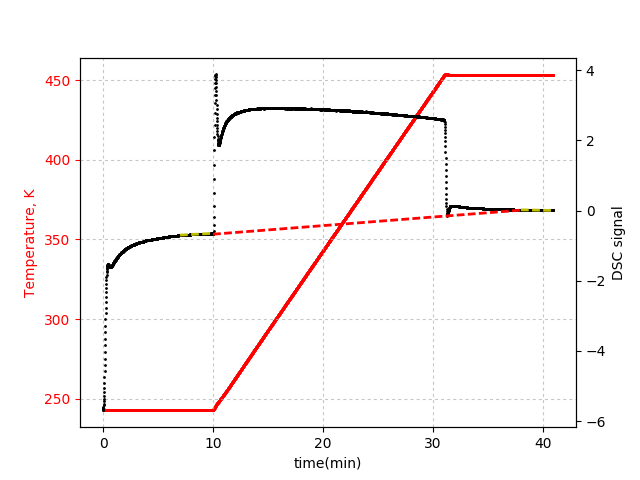

In [3]:
means = plot( time_bline, temp_bline, dsc_bline, [], bounds = [[700, 1000], [3800, 4090]] )

**Корректировка на линию дрейфа.** 

(Черный -- исходный сигнал, зеленый -- скорректированный)

[0.021850364316640558, 0.017385283784620231, 0.0089702032526000064, 0.013025122720579874, 0.019800042188559464, 0.093294961656539277, 0.25265988112451909, 0.48867480059249874, 0.81129972006047857, 1.1804346395284582]


<IPython.core.display.Javascript object>


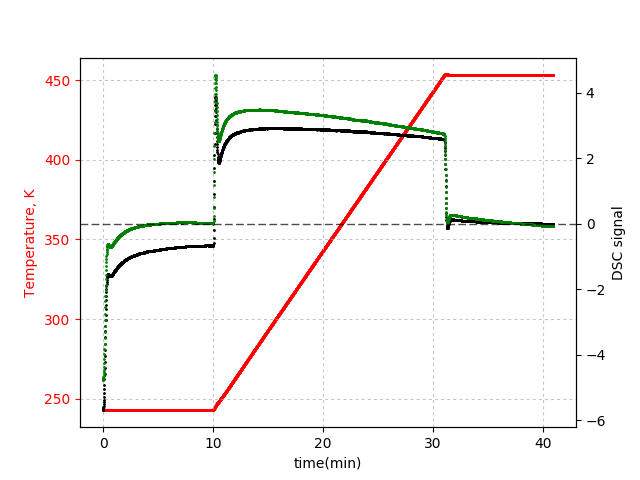

In [4]:
dsc_bline_corr = remove_drift( time_bline, dsc_bline, means )
print(dsc_bline_corr[1000:1010])

plot( time_bline, temp_bline, dsc_bline, dsc_bline_corr )

**Температурная программа и ДСК сигнал стандарта.**

[[700, 1000], [3800, 4090]]


<IPython.core.display.Javascript object>


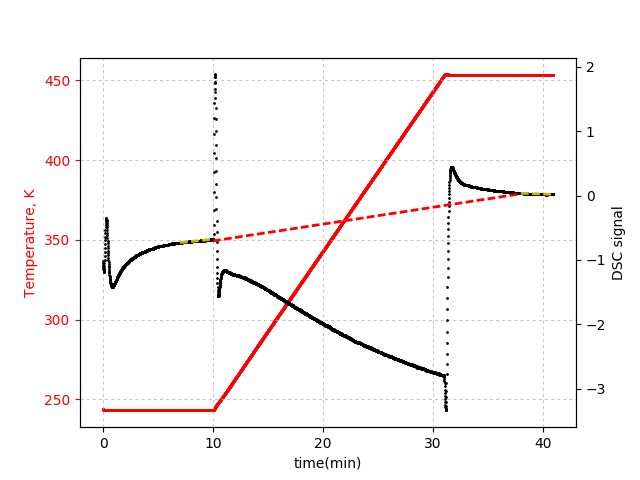

In [5]:
means = plot( time_sapp, temp_sapp, dsc_sapp, bounds = [[700, 1000], [3800, 4090]] )

**Корректированный ДСК сигнал стандарта.**

<IPython.core.display.Javascript object>


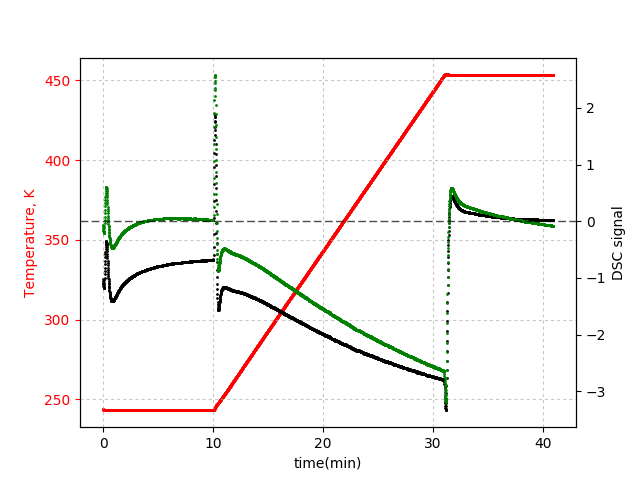

In [6]:
dsc_sapp_corr = remove_drift( time_sapp, dsc_sapp, means )

plot( time_sapp, temp_sapp, dsc_sapp, dsc_sapp_corr )

**Вычитаем корректированную базовую линию из сигнала стандарта**

<IPython.core.display.Javascript object>


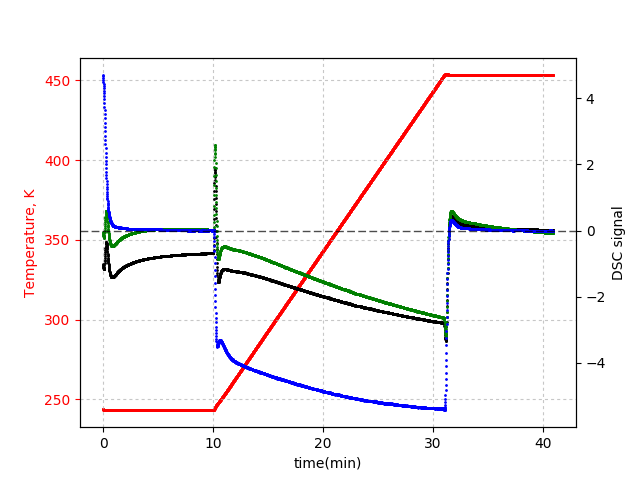

In [7]:
dsc_sapp_corr_bline = remove_bline( dsc_sapp_corr, dsc_bline_corr )

plot(time_sapp, temp_sapp, dsc_sapp, dsc_sapp_corr, dsc_sapp_corr_bline)

**Температурная программа и ДСК сигнал образца**

[[700, 1000], [3800, 4090]]


<IPython.core.display.Javascript object>


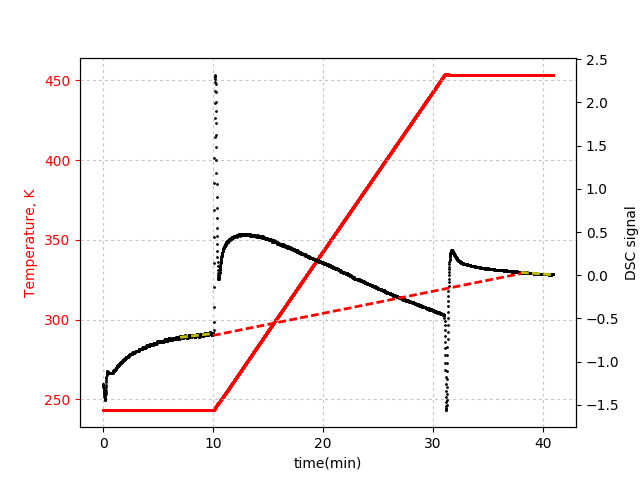

In [8]:
means = plot( time_quartz, temp_quartz, dsc_quartz, bounds = [[700, 1000], [3800, 4090]] )

**Корректированный ДСК сигнал образца**

<IPython.core.display.Javascript object>


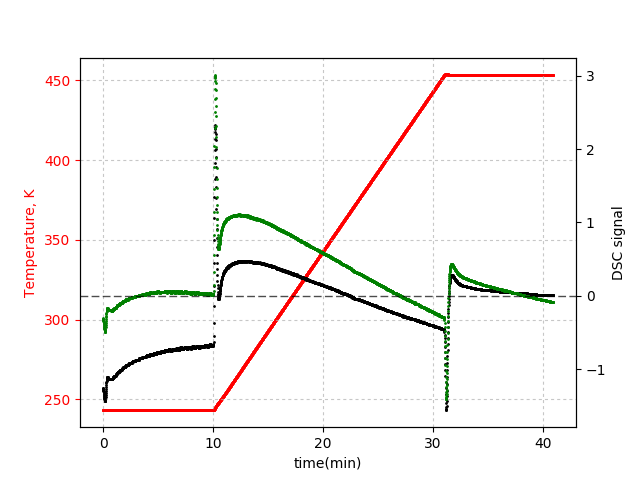

In [9]:
dsc_quartz_corr = remove_drift( time_quartz, dsc_quartz, means )

plot( time_quartz, temp_quartz, dsc_quartz, dsc_quartz_corr )

**Вычитаем корректированную базовую линию из сигнала стандарта**

<IPython.core.display.Javascript object>


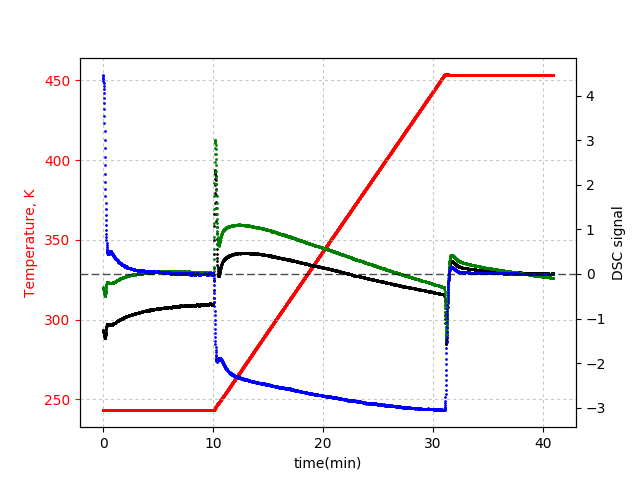

In [10]:
dsc_quartz_corr_bline = remove_bline( dsc_quartz_corr, dsc_bline_corr )

plot(time_quartz, temp_quartz, dsc_quartz, dsc_quartz_corr, dsc_quartz_corr_bline)

**Расчет теплоемкости образца**

Красная линия -- теплоемкость стандарта, синяя -- теплоемкость образца

<IPython.core.display.Javascript object>


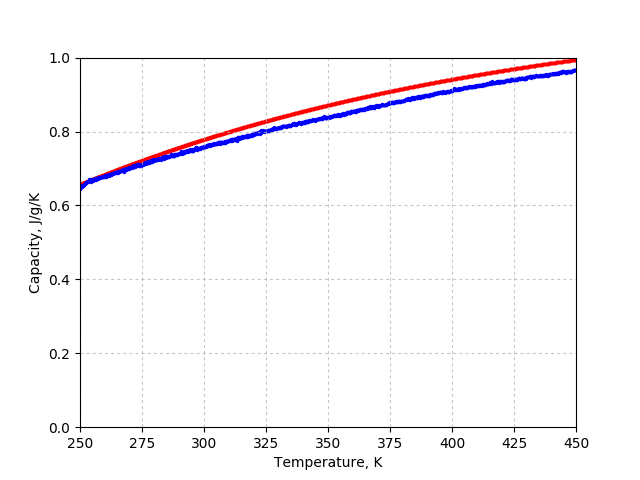

In [76]:
def plot_capacity( temp, capacity_st, capacity_q ):
    fig = plt.figure()
    plt.scatter(temp, capacity_st, s = 2.0, color = 'r')
    plt.scatter(temp, capacity_q, s = 2.0, color = 'b')
    
    plt.xlim( (250, 450) )
    plt.ylim( (0.0, 1.0) )

    plt.xlabel('Temperature, K')
    plt.ylabel('Capacity, J/g/K')
    plt.grid(linestyle = ':', alpha = 0.7)

capacity_sapp = [calc_sapp_capacity(t) for t in temp_sapp]

m_sapp = 12.69
m_q = 7.386

#print(dsc_quartz_corr_bline[2000:2010])
#print(dsc_sapp_corr_bline[2000:2010])
#print(capacity_sapp[2000:2010])

capacity_quartz = []
for dsc_q, dsc_sapp, cp_sapp in zip(dsc_quartz_corr_bline, dsc_sapp_corr_bline, capacity_sapp):
    capacity_quartz.append( m_sapp / m_q * dsc_q / dsc_sapp * cp_sapp)

plot_capacity(temp_sapp, capacity_sapp, capacity_quartz)

In [74]:
molar_mass = 60.0843
nist_temperatures = [ 298.15, 300.0, 400.0 ]
nist_cp = [ 44.57, 44.77, 53.43 ] # J/mol/K 
nist_cp = [ cp / molar_mass for cp in nist_cp ]

# Thermochimica Acta, 139 (1989) 225--243 (Series 1)
ref1_temperatures = [ 319.49, 329.68, 339.79, 349.83, 359.84, 369.79, 379.72, 389.61, 399.47, 409.30, 419.13, 428.94, 438.75, 448.56]
ref1_cp = [ 47.04, 47.93, 48.93, 49.88, 50.77, 51.64, 52.48, 53.25, 54.04, 54.77, 55.46, 56.12, 56.77, 57.41 ]
ref1_cp = [ cp / molar_mass for cp in ref1_cp ]

# Thermochimica Acta, 139 (1989) 225--243 (Series 5)
ref2_temperatures = [ 310.32, 327.27, 337.53, 347.61, 357.62, 367.53, 387.22, 397.03, 406.80, 416.57, 426.32, 445.83 ]
ref2_cp = [ 45.75, 47.47, 48.45, 49.40, 50.32, 51.19, 52.89, 53.69, 54.63, 55.18, 56.11, 56.84, 57.50 ]
ref2_cp = [ cp / molar_mass for cp in ref2_cp ]

# Thermochimica Acta, 139 (1989) 225--243 (Series 7)
ref3_temperatures = [ 322.97, 333.12, 353.26, 363.15, 373.0, 382.80, 392.58, 402.32, 412.05, 421.76, 431.47, 441.16]
ref3_cp = [ 47.17, 48.10, 49.97, 50.82, 51.61, 52.55, 53.15, 54.07, 54.65, 55.47, 55.94, 56.72 ]
ref3_cp = [ cp / molar_mass for cp in ref3_cp ]

# Thermochimica Acta, 139 (1989) 225--243 (Series 9)
ref4_temperatures = [ 322.84, 335.65, 348.33, 360.95, 373.46, 385.88, 398.22, 410.50, 422.72, 434.89 ]
ref4_cp = [ 46.85, 48.16, 49.29, 50.40, 51.44, 52.43, 53.39, 54.32, 55.16, 55.97]
ref4_cp = [ cp / molar_mass for cp in ref4_cp ]

# forming data 
# (closest exp temperature; experimental value; literature temperature; literature value; delta(%) )
def form_rows( lit_temperatures, lit_cp ):
    res = []
    for temp, cp in zip(lit_temperatures, lit_cp):
        # finding closest experimental temperature to nist temperature
        closest_temp = min(temp_sapp, key = lambda t: abs(t - temp))
        index = temp_sapp.index(closest_temp)
        cp_exp = capacity_quartz[index]
        res.append([closest_temp, cp_exp, temp, cp, abs(cp_exp - cp) / cp * 100] )
    return res

test = form_rows( nist_temperatures, nist_cp )

rows = []
rows += [['Closest expimental temperature (K)', 'Experimental value (J/g/K)', 'Literature temperature (K))', 'Literature value (J/g/K)', 'Delta(%)']]
rows += form_rows( nist_temperatures, nist_cp )
rows += form_rows( ref1_temperatures, ref1_cp )
rows += form_rows( ref2_temperatures, ref2_cp )  
rows += form_rows( ref3_temperatures, ref3_cp ) 
rows += form_rows( ref4_temperatures, ref4_cp ) 

**Создаем HTML-таблицу результатов**

In [75]:
class ListTable(list):
    
    def _repr_html_(self):
        html = "<table>"
        for row in self:
            html += "<tr>"
            for col in row:
                html += "<td>{0}</td>".format(col)
            
            html += "<tr>"
        html += "</table>"
        return ''.join(html)

html = ListTable( rows )
html


Closest expimental temperature (K),Experimental value (J/g/K),Literature temperature (K)),Literature value (J/g/K),Delta(%)
298.16281,0.753258308144,298.15,0.741791116814,1.54587876154
299.96894,0.759956498044,300.0,0.745119773385,1.99118654327
399.95991,0.913083840195,400.0,0.889250602903,2.68014856709
319.51189,0.787329887056,319.49,0.782900025464,0.565827238191
329.72419,0.808657526406,329.68,0.797712547205,1.37204551188
339.83321,0.824734508574,339.79,0.814355830059,1.2744648141
349.83994,0.83847501881,349.83,0.83016694877,1.00077099571
359.84435,0.854301361319,359.84,0.844979470511,1.1032091469
369.74819,0.871061818244,369.79,0.859459126594,1.34999923689
379.75326,0.882724059162,379.72,0.873439484191,1.06299006839
